In [1]:
import matplotlib.pyplot as plt
from sklearn import linear_model, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier

import gensim, logging
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
%matplotlib inline

In [11]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import pickle
notes = pickle.load( open( "notes.p", "rb" ) )
y = pickle.load( open( "y.p", "rb" ) )

In [3]:
y.value_counts()

1    47
0    17
dtype: int64

In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(notes, y, train_size=.80)

binary_vectorizer = CountVectorizer(stop_words = "english",binary=True, ngram_range=(1,2)).fit(X_train)
X_train_binary = binary_vectorizer.transform(X_train)
X_test_binary = binary_vectorizer.transform(X_test)
X_binary = binary_vectorizer.transform(notes)

tfidf_vectorizer = TfidfVectorizer(stop_words = "english", ngram_range=(1,2)).fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_tfidf = tfidf_vectorizer.transform(notes)

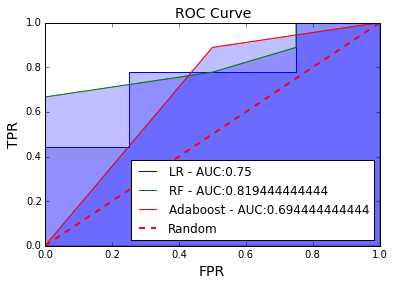

In [82]:
from sklearn.metrics import roc_curve, auc

X_train, X_test = X_train_binary, X_test_binary

#Creates the linear regression and trains it
log_regresion = linear_model.LogisticRegression(C=1e30).fit(X_train, Y_train)

#Calculating the FPR and TPR for Logistic Regresion
log_reg_preds = log_regresion.predict_proba(X_test)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, log_reg_preds[:,1])
lr_auc = auc(lr_fpr,lr_tpr)
plt.plot(lr_fpr, lr_tpr, label='LR - AUC:'+str(lr_auc))
plt.fill_between(lr_fpr,lr_tpr, alpha=0.25)

#Creates a Random Forest
rnd_forest = RandomForestClassifier(criterion='entropy', n_estimators=10).fit(X_train, Y_train)
#Calculating the FPR and TPR for Random Forest
rfor_preds = rnd_forest.predict_proba(X_test)
rfor_fpr, rfor_tpr, _ = roc_curve(Y_test, rfor_preds[:,1])
rfor_auc = auc(rfor_fpr, rfor_tpr)
plt.plot(rfor_fpr, rfor_tpr, label='RF - AUC:'+str(rfor_auc))
plt.fill_between(rfor_fpr,rfor_tpr, alpha=0.25)


# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6)).fit(X_train,Y_train)

#Calculating the FPR and TPR for Adaboost
bdt_preds = bdt.predict_proba(X_test)
bdt_fpr, bdt_tpr, _ = roc_curve(Y_test, bdt_preds[:,1])
bdt_auc = auc(bdt_fpr,bdt_tpr)
plt.plot(bdt_fpr, bdt_tpr, label='Adaboost - AUC:'+str(bdt_auc))
plt.fill_between(bdt_fpr, bdt_tpr, alpha=0.25)

plt.rcParams['figure.figsize'] = 10, 8
#Printing the random line
x = [0.0, 1.0]
plt.plot(x, x, linestyle='dashed', color='red', linewidth=2, label='Random')

plt.xlabel("FPR", fontsize=14)
plt.ylabel("TPR", fontsize=14)
plt.title("ROC Curve", fontsize=14)
plt.legend(loc=4)
plt.show()

In [12]:
def xVali(bORt):
#     sss = StratifiedShuffleSplit(y, 1,test_size=0.2)
#     for train_index, test_index in sss:
#         X_train, X_test = notes[train_index], notes[test_index]
#         Y_train, Y_test = y[train_index], y[test_index]

    global featureBinary,featureTfidf

    X_train, X_test, Y_train, Y_test = train_test_split(notes, y, train_size=0.8,stratify=y)
    
    if bORt == "binary":
        binary_vectorizer = CountVectorizer(stop_words = "english",binary=True, ngram_range=(1,2)).fit(X_train)
        X_train = binary_vectorizer.transform(X_train)
        X_test = binary_vectorizer.transform(X_test)
        feature_names = binary_vectorizer.get_feature_names()
        
    if bORt == "tfidf":
        tfidf_vectorizer = TfidfVectorizer(stop_words = "english", ngram_range=(1,2)).fit(X_train)
        X_train = tfidf_vectorizer.transform(X_train)
        X_test = tfidf_vectorizer.transform(X_test)
        feature_names = tfidf_vectorizer.get_feature_names()

    lr_grid = {'penalty':['l1','l2'],'C':[0.1,1,10]}

    kf = cross_validation.StratifiedKFold(Y_train, n_folds=4 )

    lr_cv = GridSearchCV(LogisticRegression(), lr_grid, cv = kf, scoring = 'roc_auc')
    lr_cv.fit(X_train, Y_train)
    lr_auc= metrics.roc_auc_score(Y_test,lr_cv.predict(X_test))

    cof =lr_cv.best_estimator_.coef_[0]
    cof2 = [(feature_names[i],cof[i]) for i,e in enumerate(cof) ]
    cof2.sort(key=lambda x: x[1])
    cof2 = [i[0] for i in cof2]
    cof3 = list(enumerate(cof2))
    
    if bORt == "binary":
        for k,v in cof3:            
            featureBinary[v].append(k)
            
    if bORt == "tfidf":
        for k,v in cof3:
            featureTfidf[v].append(k)
            
    return lr_auc

In [13]:
featureBinary = collections.defaultdict(list)
featureTfidf = collections.defaultdict(list)
xVali("tfidf")

0.6166666666666667

In [66]:
lr_cv

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 0 0 1 0], n_folds=3, shuffle=False, random_state=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

#### 50 run of cross validation

In [6]:
import operator
from collections import OrderedDict
import collections

In [16]:
aucBinary = []
aucTfidf = []
featureBinary = collections.defaultdict(list)
featureTfidf = collections.defaultdict(list)
for i in xrange(100):
    aucBinary.append(xVali("binary"))
    aucTfidf.append(xVali("tfidf"))
    

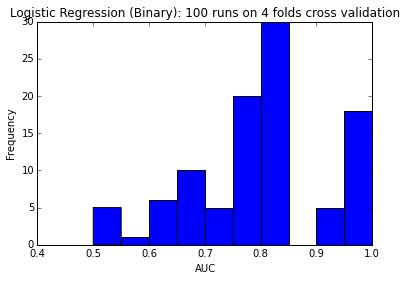

In [17]:
plt.hist(aucBinary)
plt.title("Logistic Regression (Binary): 100 runs on 4 folds cross validation ")
plt.xlabel("AUC")
plt.ylabel("Frequency")

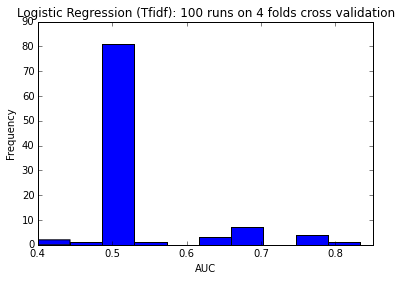

In [18]:
plt.hist(aucTfidf)
plt.title("Logistic Regression (Tfidf): 100 runs on 4 folds cross validation ")
plt.xlabel("AUC")
plt.ylabel("Frequency")

### Feature Selection - coef rank

In [19]:
import operator
from collections import OrderedDict

In [20]:
avgFeatures = collections.OrderedDict()
for k,v in featureBinary.iteritems():
    avgFeatures[k] = sum(v)/ float(len(v))

sorted_Ave = list(sorted(avgFeatures.items(), key=operator.itemgetter(1)))

In [21]:
sorted_Ave[-10:]

[(u'zyvox flagyl', 207067.98780487804),
 (u'zyvox paracentisis', 207069.9756097561),
 (u'yesterday liquid', 207096.71212121213),
 (u'yogurt breakfast', 207107.0),
 (u'yogurt broth', 207108.0),
 (u'yesterday removed', 207144.4696969697),
 (u'zero current', 207157.09638554216),
 (u'zincate capsule', 207167.4805194805),
 (u'zone predominant', 207225.02597402598),
 (u'zones prostate', 207231.44155844155)]

In [22]:
sorted_Ave[:10]

[(u'00 50', 44.5875),
 (u'00 aptt', 47.705128205128204),
 (u'00 hemoglobin', 76.33333333333333),
 (u'00 labs', 78.29113924050633),
 (u'00 na', 88.6),
 (u'00 palliative', 95.78787878787878),
 (u'00 poct', 100.93975903614458),
 (u'00 received', 103.50588235294117),
 (u'00 right', 109.76),
 (u'00 room', 110.21333333333334)]